# Feed-Forward Neural Network

### David Barranquero

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

2022-12-10 15:20:50.333337: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
%matplotlib inline

Firstly, printing the version of Tensorflow I am working with, should there be any compatibility issues.

In [3]:
print(tf.__version__)

2.10.0


Setting a random seed

In [4]:
random_number = 4760396
np.random.seed(random_number)
tf.random.set_seed(random_number)

For this task, we will be analysing the MAGIC Gamma Telescope dataset which has recorded metrics on gamma rays, and attempts to classify the recorded gamma rays as either gamma, class g, or hadron, class h. The features all relate to the telescopes imaging. The dataset is available at https://archive.ics.uci.edu/ml/datasets/MAGIC+Gamma+Telescope

## Pre-processing

We define our class labels and our column/feature labels for our dataset

In [5]:
classes = ['g', 'h']

columns = ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym',
           'fM3Long', 'fM3Trans', 'fAlpha', 'fDist', 'class']

feature_columns = ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1',
                   'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist']

Next, we read in our data.

In [6]:
magic = pd.read_csv('NNData/magic04.data', header=None)
magic.columns = columns

We look at the descriptive statistics for our data.

In [7]:
print(magic.info())
print(magic.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19020 entries, 0 to 19019
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   fLength   19020 non-null  float64
 1   fWidth    19020 non-null  float64
 2   fSize     19020 non-null  float64
 3   fConc     19020 non-null  float64
 4   fConc1    19020 non-null  float64
 5   fAsym     19020 non-null  float64
 6   fM3Long   19020 non-null  float64
 7   fM3Trans  19020 non-null  float64
 8   fAlpha    19020 non-null  float64
 9   fDist     19020 non-null  float64
 10  class     19020 non-null  object 
dtypes: float64(10), object(1)
memory usage: 1.6+ MB
None
            fLength        fWidth         fSize         fConc        fConc1  \
count  19020.000000  19020.000000  19020.000000  19020.000000  19020.000000   
mean      53.250154     22.180966      2.825017      0.380327      0.214657   
std       42.364855     18.346056      0.472599      0.182813      0.110511   
min       

We can see that there are no missing values in our dataset, and all features are continuous quantitative variables. There is also a large dispersion of value ranges among the features with both positive and negative values.

Next, we display the first few rows.

In [8]:
print(magic.head())

    fLength    fWidth   fSize   fConc  fConc1     fAsym  fM3Long  fM3Trans  \
0   28.7967   16.0021  2.6449  0.3918  0.1982   27.7004  22.0110   -8.2027   
1   31.6036   11.7235  2.5185  0.5303  0.3773   26.2722  23.8238   -9.9574   
2  162.0520  136.0310  4.0612  0.0374  0.0187  116.7410 -64.8580  -45.2160   
3   23.8172    9.5728  2.3385  0.6147  0.3922   27.2107  -6.4633   -7.1513   
4   75.1362   30.9205  3.1611  0.3168  0.1832   -5.5277  28.5525   21.8393   

    fAlpha     fDist class  
0  40.0920   81.8828     g  
1   6.3609  205.2610     g  
2  76.9600  256.7880     g  
3  10.4490  116.7370     g  
4   4.6480  356.4620     g  


Furthermore, we look at the distribution of our classes.

In [9]:
print(magic['class'].value_counts())

g    12332
h     6688
Name: class, dtype: int64


We can see that there are almost double the amount of observations for class g as there are class h. From this, we would expect better classification performance for class g than class h.

Because neural networks can only work with numerical inputs, we are going to create a mapping for our target variable using 0 for g and 1 for h. This also corresponds to their index position in the class labels vector, and will pair up with the sigmoid probabilities later on. We perform the mapping and then print out the first few rows to check that everything has worked correctly.

In [10]:
magic['class'] = magic['class'].map({'g': 0, 'h': 1})

print(magic['class'].head())

0    0
1    0
2    0
3    0
4    0
Name: class, dtype: int64


For splitting our dataset, we will perform stratified sampling via proportional allocation. This will mean that our training and test datasets will have the same class distributions as the original dataset. Stratified sampling is best performed when the mean response of the different groups in the strata are very different, and has the effect of achieving a lower sampling variance, the variance of all the possible samples I could take with a particular sampling design, when compared to simple random sampling. We perform the sampling as follows.

In [11]:
# We will use proportional allocation to perform the Stratified Sampling
# First we separate all the values of the data
magic_g = magic.index[magic['class'] == 0].tolist()
magic_h = magic.index[magic['class'] == 1].tolist()

# And store these in a list
target_classes = [magic_g, magic_h]

# Our function to split the records into training and test,
def split_train_test(df, test_ratio):
    training_idx_full = []
    test_idx_full = []
    for i in range(0, 2):  # We perform this random sampling for each stratum, labels of the target variable
        training_idx, test_idx = shuffle_and_split(target_classes[i], len(target_classes[i]), test_ratio)
        training_idx_full.extend(training_idx)
        test_idx_full.extend(test_idx)

    return df.iloc[training_idx_full].copy(), df.iloc[test_idx_full].copy()


# Our function to decide which rows will be for the test data set
def shuffle_and_split(indices, length, test_ratio):
    np.random.shuffle(indices)
    test_set_size = round(length * test_ratio)
    test_indices = indices[:test_set_size]
    train_indices = indices[test_set_size:]
    return train_indices, test_indices

We call our function to get the training and test datasets.
Our specification requires a 70/30 train/test split. Later, we will also use 10% of the training data for the validation set.

In [12]:
training_data, test_data = split_train_test(magic, 0.3)

Next, we will validate that our stratified sampling was performed correctly.

In [13]:
# Sanity checks on data size
print('\nProportion of data in Training set:', 
      round(len(training_data) / len(magic), 4))

print('Proportion of data in Test set:', 
      round(len(test_data) / len(magic), 4))


Proportion of data in Training set: 0.7
Proportion of data in Test set: 0.3


In [14]:
# Calculating how well our Stratified Sampler performed
training_prop = training_data['class'].value_counts() / len(training_data)
test_prop = test_data['class'].value_counts() / len(test_data)
original_prop = magic['class'].value_counts() / len(magic)

# Build a DF containing the performance stats
strat_stats = pd.DataFrame({
    "Training Strat": training_prop,
    "Test Strat": test_prop,
    "Original DF": original_prop,
    "Training Diff": training_prop - original_prop,
    "Test Diff": test_prop - original_prop
}).sort_index()

# Display the stats
print(strat_stats.head(10))

   Training Strat  Test Strat  Original DF  Training Diff  Test Diff
0         0.64834     0.64844      0.64837       -0.00003    0.00007
1         0.35166     0.35156      0.35163        0.00003   -0.00007


Next, we create the design matrices for our training and test datasets and remove the target variable from the datasets.

In [15]:
y_train = training_data['class'].to_numpy()
training_data = training_data.drop('class', axis=1)
X_train = training_data.to_numpy()

y_test = test_data['class'].to_numpy()
test_data = test_data.drop('class', axis=1)
X_test = test_data.to_numpy()

Neural networks perform best when some form of normalisation or standardisation is performed on the feature inputs. Scaling all features will lead to faster convergence of the gradient to a local minimum. We will use Min-Max Normalisation to shrink all values to within the 0 and 1 range, while preserving the distributional shape of the data.

In [16]:
X_train = (X_train - np.min(X_train, axis=0)) / (np.max(X_train, axis=0) - np.min(X_train, axis=0))

X_test = (X_test - np.min(X_test, axis=0)) / (np.max(X_test, axis=0) - np.min(X_test, axis=0))

Checking that the minimum value is 0 and maximum value is 1 for both datasets for each feature column.

In [17]:
print('Train Min:', np.min(X_train, axis=0))
print('Train Max:', np.max(X_train, axis=0))

print('Test Min:', np.min(X_test, axis=0))
print('Test Max:', np.max(X_test, axis=0))

Train Min: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Train Max: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test Min: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test Max: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


Next, we will take 10 percent from our training dataset to use for the validation set. Our dataset is presented with all 'g' targets first, and then all 'h' targets. So just taking from the top or tail of the dataset will result in only one class of variables to validate with. So we will take a class proportional amount from the top and tail, to be consistent with our previous stratified sampling.

In [18]:
# How many rows are we going to take in total
valid_size = round(X_train.shape[0] * 0.1)

# We calculate the index of how many 'g' rows to take.
first_part = round(valid_size * original_prop[0])

# And the index of how many 'h' rows to take.
second_part = len(X_train) - round(valid_size * original_prop[1])

# We take from the top and tail from both the features and the target
X_1, X_train, X_2 = X_train[:first_part], X_train[first_part:second_part], X_train[second_part:]
y_1, y_train, y_2 = y_train[:first_part], y_train[first_part:second_part], y_train[second_part:]

# Then vertically stack the features and horizontally stack the targets (as its a 1D array)
X_valid = np.vstack((X_1, X_2))
y_valid = np.hstack((y_1, y_2))

We now print out the shapes of each dataset, to ensure everything is correct.

In [19]:
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)

(11983, 10)
(11983,)
(1331, 10)
(1331,)
(5706, 10)
(5706,)


## Creating Our Network

Now that the pre-processing is complete, we are ready to build our neural network. Generally, better performance on neural networks can be achieved by building a network that has fewer parameters and more layers. This is because it can reduce overparameterising our model and overfitting to our training data, but also by more layers, we promote the feature construction by the network in identifying lines and shapes, then features, then the object. As a starting point, we will construct an initial network with 3 hidden layers and 50 neurons, as an educated guess of what will produce a good classification model.

The input layer can be specified in the first hidden layer using the input_dim parameter. Here we specify that the input is 10 feature columns. We will be using the ReLU activation function for our hidden layers, where ReLU(a) = max(0,a). ReLU is commonly used in state-of-the-art deep learning technologies, such as facial recognition technology, as it eliminates the vanishing/exploding gradient of earlier activations such as the sigmoid activation, as the derivative of ReLU for positive values is 1, avoiding small number multiplications through the chain rule when calculating the gradient of the loss function. Furthermore ReLU also promotes sparsity by setting negatively activated neurons to 0, leading to faster calculations and gradient convergence. 

Because we are performing binary classificaton, we will just have one neuron in the final layer, which produces a probability of the positive class. The sigmoid function, which maps the real number line to the (0,1) interval, is most commonly used in logistic regression in modelling the log-odds of a binary target variable. Given how we have coded our classes as 0 or 1 and indexed the labels, a probability closer to 0 indicates the 0 mapped class which is at index 0 of the labels, so class 'g'. A probability closer to 1 is the opposite, we predict class 'h'.

In [20]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(50, input_dim=10, activation='relu'))
model.add(keras.layers.Dense(50, activation='relu'))
model.add(keras.layers.Dense(50, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

2022-12-10 15:21:01.517317: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


With regards to the model summary, we can see the number of parameters (weights and biases) in each layer. So our first layer has 10 input features, 10 weights per feature plus 1 bias per neuron for 50 neurons, so 550 parameters in total.

We can view the dimensions of these weights and biases as follows.

In [21]:
weights, biases = model.layers[0].get_weights()

print(weights.shape)
print(biases.shape)

(10, 50)
(50,)


Now that we have constructed our model, we need to compile it. For our gradient optimiser, we will use stochastic gradient descent (SGD). Rather than performing the back-propagation to train a neural network on the entire dataset, which is computationally intensive and time consuming, we will only use a sample of our data. This leads to faster, more imprecise steps towards to gradient functions local minimum, rather than slower, more calculated steps. As an added advantage, the imprecision of the steps can lead to us overshooting the descent, and leaving the local minima region towards the global minima.

Our loss function will be binary cross-entropy, as we are performing binary classification on with our model. Furthermore as this is a classification problem, this means that our performance metric will be accuracy.

In [22]:
model.compile(optimizer='SGD', loss='binary_crossentropy', metrics=['accuracy'])

Finally, we fit our model to the training data. As in the lab, we will use 15 epochs, or sweeps over the entire data in our training. We will also use our validation dataset to assess the model fit, and detect any overfitting that may occur.

In [23]:
n_epochs = 10
fitted_model = model.fit(X_train, y_train, epochs=n_epochs, 
                         validation_data=(X_valid, y_valid))

Epoch 1/10
375/375 [==============================] - 2s 3ms/step - loss: 0.6374 - accuracy: 0.6500 - val_loss: 0.6090 - val_accuracy: 0.6484
Epoch 2/10
375/375 [==============================] - 1s 2ms/step - loss: 0.5804 - accuracy: 0.6980 - val_loss: 0.5529 - val_accuracy: 0.7355
Epoch 3/10
375/375 [==============================] - 1s 2ms/step - loss: 0.5235 - accuracy: 0.7582 - val_loss: 0.5065 - val_accuracy: 0.7618
Epoch 4/10
375/375 [==============================] - 1s 2ms/step - loss: 0.4893 - accuracy: 0.7748 - val_loss: 0.4846 - val_accuracy: 0.7829
Epoch 5/10
375/375 [==============================] - 1s 2ms/step - loss: 0.4696 - accuracy: 0.7874 - val_loss: 0.4675 - val_accuracy: 0.7874
Epoch 6/10
375/375 [==============================] - 1s 2ms/step - loss: 0.4534 - accuracy: 0.7965 - val_loss: 0.4541 - val_accuracy: 0.7994
Epoch 7/10
375/375 [==============================] - 1s 2ms/step - loss: 0.4399 - accuracy: 0.8021 - val_loss: 0.4460 - val_accuracy: 0.7956
Epoch 

We can visualise the training accuracy and loss, as well as that of the validation set via a plot.

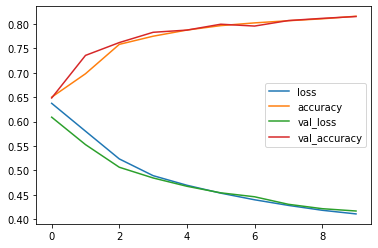

In [24]:
pd.DataFrame(fitted_model.history).plot()
plt.show()

From this plot, we can observe strong model performance. With the successive sweeps over the dataset, our models training accuracy has continued to rise, and the loss has continued to decrease, which indicates that our model is updating the weights and biases in a correct manner. 

Furthermore, the validation accuracy and loss is close to that of the training set. If our model was overfitting, we would expect to see strong training accuracy, but poor validation accuracy, as our model fits too closely to the noise of individual observations and does not generalise well. As this is not observed, this is a good thing and suggests our model is NOT overfitting.

Next, we will evaluate the models performance on the test set.

In [25]:
print(model.evaluate(X_test, y_test))

179/179 [==============================] - 0s 2ms/step - loss: 0.4149 - accuracy: 0.8214
[0.4149346947669983, 0.8214160799980164]


Overall, this is a strong test accuracy for our model, and indicates a strong overall classification ability.

Before we begin fine-tuning the model, we want to ensure that the model is behaving correctly and producing valid output. There is no point trying to optimise a model which is not giving valid output. We will assess the predictions for both some observations from class g and some from class h.

In [26]:
# Let's try predicting some 'g' classes
X_new = X_test[:3]
y_prob = model.predict(X_new)
y_pred = np.round([y_prob[0][0], y_prob[1][0], y_prob[2][0]])
print('Predicted:', y_pred)
print('True: ', y_test[:3])

1/1 [==============================] - 0s 98ms/step
Predicted: [0. 0. 0.]
True:  [0 0 0]


In [27]:
# And now some 'h' classes
X_new = X_test[-3:]
y_prob = model.predict(X_new)
y_pred = np.round([y_prob[0][0], y_prob[1][0], y_prob[2][0]])
print('Predicted:', y_pred)
print('True: ', y_test[-3:])

1/1 [==============================] - 0s 22ms/step
Predicted: [0. 0. 1.]
True:  [1 1 1]


As we can see, our model is producing valid output. In this little sample, we are also performing better at classifying the 'g' class than the 'h' class. This is likely an effect of 'g' having almost double the observations as 'h' in the training dataset, and so we are observing better classification performance for 'g'.

Next, we will move onto hyperparameter fine-tuning.

## Fine-Tuning Hyperparameters

To fine-tune our hyperparameters for our model, we will be performing grid search via cross-validation. We will be wrapping the code we used to implement our model in a function and then wrapping this in a KerasClassifier wrapper so that we can use the Scikit Learn GridSearchCV function with our keras model.

In [28]:
def build_model(n_hidden, n_neurons):
    print('\nn_hidden={0}, n_neurons={1}'
          .format(n_hidden, n_neurons))
    
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(n_neurons, input_dim=10, activation='relu'))
    for _ in range(n_hidden - 1):
        model.add(keras.layers.Dense(n_neurons, activation='relu'))
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='SGD', 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    
    return model

keras_classifier = keras.wrappers.scikit_learn.KerasClassifier(build_model)

/var/folders/f_/3vhcqh5j54n5rh_ffnt1jks80000gn/T/ipykernel_98751/3954053308.py:17: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_classifier = keras.wrappers.scikit_learn.KerasClassifier(build_model)


With regards to the hyperparameter grid to trial, we will be trialing two different components. Firstly, the number of hidden layers, we will trial both our three hidden layer model, and a deeper 4 hidden layer model. We will also test to see what the optimal number of neurons is. Again we have our default amount from the previous model, and also double the amount.

In [29]:
params_to_try = {
    'n_hidden': [3, 4],
    'n_neurons': [50, 100]
}

We are also going to include a callback with a patience of 5. This is used to stop training early if we observe the loss begin to rise, or accuracy begin to decrease, suggesting we have reached either a minumum or maximum respectively. The patience of 5 means we wait for 5 epochs without change before halting.

In total, we have two parameters with two possible values, hence 2x2 = 4 possible combinations. This combined with 5-fold cross validation, and 10 epochs, with a 1 second training time per epoch suggests a 4x5x10/60 = 3.33 minute optimisation time.

In [30]:
grid_search = GridSearchCV(keras_classifier, params_to_try, cv=5)

grid_search.fit(X_train, 
                y_train, 
                epochs=n_epochs, 
                validation_data=(X_valid, y_valid),
                callbacks=[keras.callbacks.EarlyStopping(patience=10)])


n_hidden=3, n_neurons=50
Epoch 1/10
300/300 [==============================] - 1s 3ms/step - loss: 0.6770 - accuracy: 0.5610 - val_loss: 0.6408 - val_accuracy: 0.6514
Epoch 2/10
300/300 [==============================] - 1s 2ms/step - loss: 0.6450 - accuracy: 0.6393 - val_loss: 0.6040 - val_accuracy: 0.7318
Epoch 3/10
300/300 [==============================] - 1s 2ms/step - loss: 0.6003 - accuracy: 0.7166 - val_loss: 0.5596 - val_accuracy: 0.7588
Epoch 4/10
300/300 [==============================] - 1s 2ms/step - loss: 0.5491 - accuracy: 0.7510 - val_loss: 0.5155 - val_accuracy: 0.7746
Epoch 5/10
300/300 [==============================] - 1s 2ms/step - loss: 0.5139 - accuracy: 0.7639 - val_loss: 0.4902 - val_accuracy: 0.7866
Epoch 6/10
300/300 [==============================] - 1s 2ms/step - loss: 0.4937 - accuracy: 0.7719 - val_loss: 0.4876 - val_accuracy: 0.7934
Epoch 7/10
300/300 [==============================] - 1s 2ms/step - loss: 0.4802 - accuracy: 0.7788 - val_loss: 0.4606 - v

300/300 [==============================] - 1s 2ms/step - loss: 0.5636 - accuracy: 0.7383 - val_loss: 0.5353 - val_accuracy: 0.7686
Epoch 5/10
300/300 [==============================] - 1s 2ms/step - loss: 0.5254 - accuracy: 0.7552 - val_loss: 0.4991 - val_accuracy: 0.7769
Epoch 6/10
300/300 [==============================] - 1s 2ms/step - loss: 0.5019 - accuracy: 0.7683 - val_loss: 0.4938 - val_accuracy: 0.7919
Epoch 7/10
300/300 [==============================] - 1s 2ms/step - loss: 0.4871 - accuracy: 0.7777 - val_loss: 0.4683 - val_accuracy: 0.7889
Epoch 8/10
300/300 [==============================] - 1s 2ms/step - loss: 0.4746 - accuracy: 0.7802 - val_loss: 0.4517 - val_accuracy: 0.7911
Epoch 9/10
300/300 [==============================] - 1s 2ms/step - loss: 0.4638 - accuracy: 0.7845 - val_loss: 0.4446 - val_accuracy: 0.7964
Epoch 10/10
75/75 [==============================] - 0s 2ms/step - loss: 0.3935 - accuracy: 0.8515

n_hidden=3, n_neurons=100
Epoch 1/10
300/300 [=============

Epoch 8/10
300/300 [==============================] - 1s 2ms/step - loss: 0.4755 - accuracy: 0.7809 - val_loss: 0.4514 - val_accuracy: 0.7889
Epoch 9/10
300/300 [==============================] - 1s 2ms/step - loss: 0.4651 - accuracy: 0.7817 - val_loss: 0.4429 - val_accuracy: 0.7896
Epoch 10/10
75/75 [==============================] - 0s 2ms/step - loss: 0.3691 - accuracy: 0.8352

n_hidden=4, n_neurons=50
Epoch 1/10
300/300 [==============================] - 1s 3ms/step - loss: 0.6773 - accuracy: 0.5604 - val_loss: 0.6468 - val_accuracy: 0.6484
Epoch 2/10
300/300 [==============================] - 1s 2ms/step - loss: 0.6556 - accuracy: 0.5920 - val_loss: 0.6150 - val_accuracy: 0.7062
Epoch 3/10
300/300 [==============================] - 1s 2ms/step - loss: 0.6175 - accuracy: 0.6908 - val_loss: 0.5714 - val_accuracy: 0.7506
Epoch 4/10
300/300 [==============================] - 1s 2ms/step - loss: 0.5676 - accuracy: 0.7362 - val_loss: 0.5246 - val_accuracy: 0.7678
Epoch 5/10
300/300 [===

Epoch 1/10
300/300 [==============================] - 1s 3ms/step - loss: 0.6712 - accuracy: 0.5972 - val_loss: 0.6361 - val_accuracy: 0.6905
Epoch 2/10
300/300 [==============================] - 1s 3ms/step - loss: 0.6291 - accuracy: 0.6919 - val_loss: 0.5818 - val_accuracy: 0.7363
Epoch 3/10
300/300 [==============================] - 1s 2ms/step - loss: 0.5680 - accuracy: 0.7409 - val_loss: 0.5290 - val_accuracy: 0.7769
Epoch 4/10
300/300 [==============================] - 1s 2ms/step - loss: 0.5207 - accuracy: 0.7610 - val_loss: 0.4952 - val_accuracy: 0.7874
Epoch 5/10
300/300 [==============================] - 1s 2ms/step - loss: 0.4952 - accuracy: 0.7728 - val_loss: 0.4654 - val_accuracy: 0.7956
Epoch 6/10
300/300 [==============================] - 1s 2ms/step - loss: 0.4761 - accuracy: 0.7796 - val_loss: 0.4622 - val_accuracy: 0.8024
Epoch 7/10
300/300 [==============================] - 1s 2ms/step - loss: 0.4617 - accuracy: 0.7818 - val_loss: 0.4379 - val_accuracy: 0.7994
Epoch 

GridSearchCV(cv=5,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7f8d597c16d0>,
             param_grid={'n_hidden': [3, 4], 'n_neurons': [50, 100]})

After optimisation, we observe that our best model parameters are as follows.

In [31]:
print(grid_search.best_params_)

{'n_hidden': 4, 'n_neurons': 100}


These parameters produced the optimal cross validated accuracy on the validation set of,

In [32]:
print(grid_search.best_score_)

0.7292508482933044


We can save this model in a variable, and display the network structure as follows

In [33]:
best_model = grid_search.best_estimator_.model

print(best_model.summary())

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_94 (Dense)            (None, 100)               1100      
                                                                 
 dense_95 (Dense)            (None, 100)               10100     
                                                                 
 dense_96 (Dense)            (None, 100)               10100     
                                                                 
 dense_97 (Dense)            (None, 100)               10100     
                                                                 
 dense_98 (Dense)            (None, 1)                 101       
                                                                 
Total params: 31,501
Trainable params: 31,501
Non-trainable params: 0
_________________________________________________________________
None


Finally, we display the test accuracy of our optimal model.

In [34]:
print(best_model.evaluate(X_test, y_test))

179/179 [==============================] - 0s 2ms/step - loss: 0.3947 - accuracy: 0.8342
[0.39470264315605164, 0.8342096209526062]


While this is only a slight improvement, it has resulted in a neural network with higher classification accuracy. With regards to our original dataset, this means that we are able to better distinguish between the gamma rays as either gamma or hadron.